In [0]:
import warnings
warnings.filterwarnings("ignore")

import sqlite3
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import nltk
import string
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer
from sklearn.decomposition import TruncatedSVD

import re
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

from sklearn.cross_validation import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.cross_validation import cross_val_score
from collections import Counter
from sklearn.metrics import accuracy_score
from sklearn import cross_validation
from prettytable import PrettyTable

import xgboost as xgb
from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import RandomForestClassifier

# Import the data

In [0]:
import pandas as pd
final = pd.read_csv("final.csv")
p = final.groupby('Score')
pos = p.get_group('Positive') #Gets the groups with Positive score
neg = p.get_group('Negative') #Gets the groups with Negative score
pos_2000 = pos.sample(142897) #Gets 1000 reviews of positive and negative scores
neg_2000 = neg.sample(57103)
grouped_data = pd.concat([pos_2000, neg_2000], ignore_index = True) #This data now contains positive and negative data in order.
print("The shape of grouped data is {}".format(grouped_data.shape))

Observations:
We choose 142897 positive and 57103 negative reviews from the final dataframe obtained after data cleaning process.

In [0]:
import datetime
grouped_data['Time'] = grouped_data['Time'].map(lambda a: datetime.datetime.fromtimestamp(int(a)).strftime('%Y-%m-%d %H:%M:%S'))
grouped_data = grouped_data.sort_values('Time', axis=0, ascending=True, kind='quicksort')
scores = grouped_data['Score']
print("The shape of grouped data after time based splitting is {}".format(grouped_data.shape))

Observations:
Time based splitting is done on the obtained dataframe.

In [0]:
grouped_data.to_csv("grouped_data_200")

Observations:
Saving this dataframe into a new csv file.

# Utility Functions

In [0]:
#We create a few utility functions whose use is described below


def xgb_gbdt(x_train,y_train,x_test,y_test,words): #Perform XGBoost, plot confusion matrix and get feature importances
    my_cv = TimeSeriesSplit(n_splits=10).split(x_train)
    param_grid = {'n_estimators' : list(range(100,301,100)), 'max_depth' : list(range(10,16,5)), 'learning_rate' : [0.01, 0.1, 0.2]} #Parameters for grid search
    model1 = xgb.XGBClassifier()
    f1_scorer = make_scorer(f1_score, pos_label='Positive') #This lets the f1 scorer know that positive label is 'Positive'
    
    gsearch1 = GridSearchCV(estimator = model1, param_grid = param_grid,cv=my_cv, scoring = f1_scorer) #Initiate GridsearchCV
    gsearch1.fit(x_train, y_train) #Fitting the model
    print("The optimal base learners found using GridSearchCV is",gsearch1.best_params_['n_estimators'])
    print("The optimal max depth found using GridSearchCV is",gsearch1.best_params_['max_depth'])
    print("The optimal learning rate found using GridSearchCV is",gsearch1.best_params_['learning_rate'])
    print("The best CV value found is",gsearch1.best_index_)
    
    gpred1 = gsearch1.predict(x_test) #Predicting test data
    print('\nThe test accuracy of SVM for max_depth = %d is %f%%' % (gsearch1.best_params_['max_depth'], accuracy_score(y_test, gpred1) * 100))
    print('\nThe test precision of SVM for max_depth = %d is %f%%' % (gsearch1.best_params_['max_depth'], precision_score(y_test,gpred1,pos_label='Positive')*100))
    print('\nThe test recall of SVM for max_depth = %d is %f%%' % (gsearch1.best_params_['max_depth'], recall_score(y_test,gpred1,pos_label='Positive')*100))
    print('\nThe test f1 score of SVM for max_depth = %d is %f%%' % (gsearch1.best_params_['max_depth'], f1_score(y_test,gpred1,pos_label='Positive')*100))
    print('*'*50)
    
    
    #Plot confusion matrix
    
    #We are using 2 types of confusion matrix here. SKLearn confusion matrix and pandas_ml confusion matrix.
    #SKLearn confusion matrix is used to plot it diagramatically whereas pandas_ml confusion matrix is used just for intresting stats like TPR, TNR etc..
    
    
    y_true = np.array(y_test) #Converting y_test and gpred1 to array for input into pandas_ml Confusion matrix
    y_pred = np.array(gpred1)
    labels = ['Negative','Positive']
    print(confusion_matrix(y_test, gpred1)) #This prints TP, TN, FP, FN numerically before plotting it diagramatically.
    cm = ConfusionMatrix(np.where(y_true == 'Positive', True, False), np.where(y_pred == 'Negative',False, True)) #This the confusion matrix of pandas_ml which provides interesting stats.
    confusion_matrix_plot = confusion_matrix(y_test,gpred1) #We are plotting confusion matrix of sklearn
    heatmap = sns.heatmap(confusion_matrix_plot, annot=True,cmap='Blues', fmt='g',xticklabels=['Negative','Positive'],yticklabels=['Negative','Positive'])
    plt.title('Confusion matrix of the classifier')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()
    print("*"*50)
    print("The True Positive Rate observed is",cm.TPR) #This prints the True Positive Rate of the confusion matrix (using pandas_ml confusion matrix).
    print("The True Negative Rate observed is",cm.TNR)
    print("The False Positive Rate observed is",cm.FPR)
    print("The False Negative Rate observed is",cm.FNR)
    print("*"*50)
    print("The stats observed for confusion matrix are:")
    cm.print_stats()#Prints all the stats of the confusion matrix plotted (using pandas_ml confusion matrix).
    
    print('\n')
    
    
    if len(x_train[0])!=len(words): #This checks if the n_features matches with the number of words. Only matches for BOW and TFIDF.
        words=None #If they dont match then feature names in the decision tree graph will be set to None.
    
    print('\n')
    print('*'*70)
        
    if words == None: #If the input is 1, a dataframe is output with important features.
        df = 0 #If input is 0 the data frame is not obtained.        
    else:
        #Get feature Importances
        clf = gsearch1.best_estimator_
        clf.fit(x_train,y_train)
        feat_imps = clf.feature_importances_ #Storing the feature importances into a new variable
        
        df = pd.DataFrame({'Words': words, 'Coefficients':feat_imps}) #Create a dataframe for feature importances of all the words
    return df

def rf_classifier(x_train,y_train,x_test,y_test,words): #Perform random forests, plot confusion matrix and get feature importances
    my_cv = TimeSeriesSplit(n_splits=10).split(x_train)
    param_grid = {'n_estimators' : list(range(100,1001,100))} #Parameters for grid search
    model1 = RandomForestClassifier()
    f1_scorer = make_scorer(f1_score, pos_label='Positive') #This lets the f1 scorer know that positive label is 'Positive'
    
    gsearch1 = GridSearchCV(estimator = model1, param_grid = param_grid,cv=my_cv, scoring = f1_scorer) #Initiate GridsearchCV
    gsearch1.fit(x_train, y_train) #Fitting the model
    print("The optimal base learners found using GridSearchCV is",gsearch1.best_params_['n_estimators'])
    print("The best CV value found is",gsearch1.best_index_)
    
    gpred1 = gsearch1.predict(x_test) #Predicting test data
    print('\nThe test accuracy of SVM for n_estimators = %d is %f%%' % (gsearch1.best_params_['n_estimators'], accuracy_score(y_test, gpred1) * 100))
    print('\nThe test precision of SVM for n_estimators = %d is %f%%' % (gsearch1.best_params_['n_estimators'], precision_score(y_test,gpred1,pos_label='Positive')*100))
    print('\nThe test recall of SVM for n_estimators = %d is %f%%' % (gsearch1.best_params_['n_estimators'], recall_score(y_test,gpred1,pos_label='Positive')*100))
    print('\nThe test f1 score of SVM for n_estimators = %d is %f%%' % (gsearch1.best_params_['n_estimators'], f1_score(y_test,gpred1,pos_label='Positive')*100))
    print('*'*50)
    
    
    #Plot confusion matrix
    
    #We are using 2 types of confusion matrix here. SKLearn confusion matrix and pandas_ml confusion matrix.
    #SKLearn confusion matrix is used to plot it diagramatically whereas pandas_ml confusion matrix is used just for intresting stats like TPR, TNR etc..
    
    
    y_true = np.array(y_test) #Converting y_test and gpred1 to array for input into pandas_ml Confusion matrix
    y_pred = np.array(gpred1)
    labels = ['Negative','Positive']
    print(confusion_matrix(y_test, gpred1)) #This prints TP, TN, FP, FN numerically before plotting it diagramatically.
    cm = ConfusionMatrix(np.where(y_true == 'Positive', True, False), np.where(y_pred == 'Negative',False, True)) #This the confusion matrix of pandas_ml which provides interesting stats.
    confusion_matrix_plot = confusion_matrix(y_test,gpred1) #We are plotting confusion matrix of sklearn
    heatmap = sns.heatmap(confusion_matrix_plot, annot=True,cmap='Blues', fmt='g',xticklabels=['Negative','Positive'],yticklabels=['Negative','Positive'])
    plt.title('Confusion matrix of the classifier')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()
    print("*"*50)
    print("The True Positive Rate observed is",cm.TPR) #This prints the True Positive Rate of the confusion matrix (using pandas_ml confusion matrix).
    print("The True Negative Rate observed is",cm.TNR)
    print("The False Positive Rate observed is",cm.FPR)
    print("The False Negative Rate observed is",cm.FNR)
    print("*"*50)
    print("The stats observed for confusion matrix are:")
    cm.print_stats()#Prints all the stats of the confusion matrix plotted (using pandas_ml confusion matrix).
    
    print('\n')
    
    
    if len(x_train[0])!=len(words): #This checks if the n_features matches with the number of words. Only matches for BOW and TFIDF.
        words=None #If they dont match then feature names in the decision tree graph will be set to None.
    
    print('\n')
    print('*'*70)
        
    if words == None: #If the input is 1, a dataframe is output with important features.
        df = 0 #If input is 0 the data frame is not obtained.        
    else:
        #Get feature Importances
        clf = gsearch1.best_estimator_
        clf.fit(x_train,y_train)
        feat_imps = clf.feature_importances_ #Storing the feature importances into a new variable
        
        df = pd.DataFrame({'Words': words, 'Coefficients':feat_imps}) #Create a dataframe for feature importances of all the words
    return df

**Observations:**

1) The first function finds the number of base learners, maximum depth and learning rate for XGBClassifier, plots confusion matrix and lists all of its stats using GridsearchCV. 

2) It also returns a dataframe with all the important features. 

3) The second function finds the number of base learners for RandomForestClassifier, plots confusion matrix and lists all of its stats using GridSearchCV. 

4) It also returns a dataframe with all the important features.

# Bag of Words

In [0]:
import pandas as pd
final = pd.read_csv("grouped_data_200.csv")
p = final.groupby('Score')
pos = p.get_group('Positive') #Gets the groups with Positive score
neg = p.get_group('Negative') #Gets the groups with Negative score
pos_2000 = pos.sample(12000) #Gets 12000 reviews of positive and 8000 negative scores
neg_2000 = neg.sample(8000)
grouped_data = pd.concat([pos_2000, neg_2000], ignore_index = True) #This data now contains positive and negative data in order.
grouped_data.dropna(inplace = True) #Drops rows with Nan
grouped_data.reset_index(inplace=True) #Replaces missing indexes
grouped_data.drop(['Unnamed: 0', 'Unnamed: 0.1'], axis=1, inplace=True)
grouped_data = grouped_data.sort_values('Time', axis=0, ascending=True, kind='quicksort')
scores=grouped_data['Score']
print("The shape of grouped data is {}".format(grouped_data.shape))

The shape of grouped data is (19999, 12)


Observations:
A csv file is imported which consists of 200000 data points. These data points are already sorted on the basis of time. We create a new dataframe with over 20000 data points.

In [0]:
x_train, x_test, y_train, y_test = train_test_split(grouped_data,scores,test_size=0.3,shuffle=False)

Observations:
The data is split into train and test.

In [0]:
count_vect = CountVectorizer()
vocab = count_vect.fit(x_train['CleanedText'].values.astype('U'))
data_train = count_vect.transform(x_train['CleanedText'].values.astype('U'))
data_test = count_vect.transform(x_test['CleanedText'].values.astype('U'))
words = count_vect.get_feature_names()
print("The shape of train data for BOW is {}".format(data_train.shape))
print("The shape of test data for BOW is {}".format(data_test.shape))

The shape of train data for BOW is (13999, 15322)
The shape of test data for BOW is (6000, 15322)


Observations:
We build out Bag of words vocabulary only on train data and get vectors of train and test data.

In [0]:
from sklearn.preprocessing import normalize
data_train=normalize(data_train)
data_test=normalize(data_test)

Observations: We normalize the data.

The optimal base learners found using GridSearchCV is 300
The optimal max depth found using GridSearchCV is 10
The optimal learning rate found using GridSearchCV is 0.2
The best CV value found is 14

The test accuracy of SVM for max_depth = 10 is 85.733333%

The test precision of SVM for max_depth = 10 is 85.346535%

The test recall of SVM for max_depth = 10 is 89.925484%

The test f1 score of SVM for max_depth = 10 is 87.576197%
**************************************************
[[2127  518]
 [ 338 3017]]


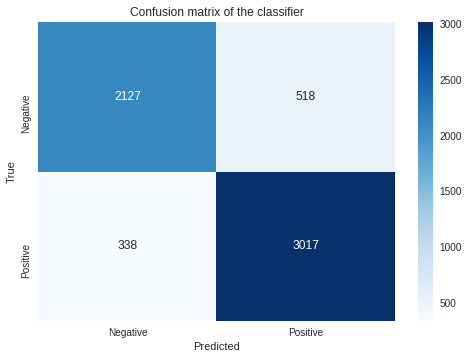

**************************************************
The True Positive Rate observed is 0.8992548435171386
The True Negative Rate observed is 0.8041587901701324
The False Positive Rate observed is 0.19584120982986766
The False Negative Rate observed is 0.1007451564828614
**************************************************
The stats observed for confusion matrix are:
population: 6000
P: 3355
N: 2645
PositiveTest: 3535
NegativeTest: 2465
TP: 3017
TN: 2127
FP: 518
FN: 338
TPR: 0.8992548435171386
TNR: 0.8041587901701324
PPV: 0.8534653465346534
NPV: 0.8628803245436105
FPR: 0.19584120982986766
FDR: 0.14653465346534653
FNR: 0.1007451564828614
ACC: 0.8573333333333333
F1_score: 0.8757619738751814
MCC: 0.7098502035424856
informedness: 0.703413633687271
markedness: 0.7163456710782641
prevalence: 0.5591666666666667
LRP: 4.591754944213961
LRN: 0.12528017813689157
DOR: 36.6518870941948
FOR: 0.13711967545638945


The number of words available are 15322


In [0]:
df = xgb_gbdt(data_train, y_train, data_test, y_test, words)

In [0]:
df.sort_values(['Coefficients'], ascending=False).head(15)

,Coefficients,Words
7662,0.035457,like
13321,0.035017,tast
10506,0.024283,product
5655,0.022523,good
9331,0.021731,one
4943,0.021116,flavor
15078,0.020412,would
13865,0.019004,tri
7839,0.016189,love
5782,0.014869,great


The optimal base learners found using GridSearchCV is 400
The best CV value found is 3

The test accuracy of SVM for n_estimators = 400 is 83.600000%

The test precision of SVM for n_estimators = 400 is 80.358515%

The test recall of SVM for n_estimators = 400 is 93.532042%

The test f1 score of SVM for n_estimators = 400 is 86.446281%
**************************************************
[[1878  767]
 [ 217 3138]]


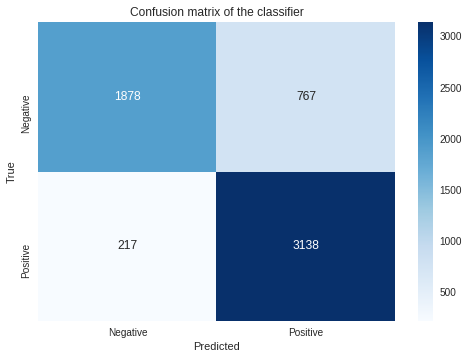

**************************************************
The True Positive Rate observed is 0.9353204172876304
The True Negative Rate observed is 0.7100189035916824
The False Positive Rate observed is 0.2899810964083176
The False Negative Rate observed is 0.0646795827123696
**************************************************
The stats observed for confusion matrix are:
population: 6000
P: 3355
N: 2645
PositiveTest: 3905
NegativeTest: 2095
TP: 3138
TN: 1878
FP: 767
FN: 217
TPR: 0.9353204172876304
TNR: 0.7100189035916824
PPV: 0.803585147247119
NPV: 0.8964200477326969
FPR: 0.2899810964083176
FDR: 0.19641485275288093
FNR: 0.0646795827123696
ACC: 0.836
F1_score: 0.8644628099173554
MCC: 0.6721167139271761
informedness: 0.6453393208793128
markedness: 0.7000051949798158
prevalence: 0.5591666666666667
LRP: 3.2254530687428713
LRN: 0.09109557842077613
DOR: 35.407350440702
FOR: 0.1035799522673031


The number of words available are 15322


In [0]:
df = rf_classifier(data_train, y_train, data_test, y_test, words)

In [0]:
df.sort_values(['Coefficients'], ascending=False).head(15)

,Coefficients,Words
5782,0.017341,great
3742,0.012915,disappoint
7839,0.011909,love
1204,0.008967,best
13321,0.007382,tast
8608,0.007250,money
15078,0.007040,would
5655,0.006831,good
11210,0.006457,return
3487,0.006121,delici


# TFIDF

In [0]:
import pandas as pd
final = pd.read_csv("grouped_data_200.csv")
p = final.groupby('Score')
pos = p.get_group('Positive') #Gets the groups with Positive score
neg = p.get_group('Negative') #Gets the groups with Negative score
pos_2000 = pos.sample(3000) #Gets 3000 reviews of positive and 2000 negative scores
neg_2000 = neg.sample(2000)
grouped_data = pd.concat([pos_2000, neg_2000], ignore_index = True) #This data now contains positive and negative data in order.
grouped_data.dropna(inplace = True) #Drops rows with Nan
grouped_data.reset_index(inplace=True) #Replaces missing indexes
grouped_data.drop(['Unnamed: 0', 'Unnamed: 0.1'], axis=1, inplace=True)
grouped_data = grouped_data.sort_values('Time', axis=0, ascending=True, kind='quicksort')
scores=grouped_data['Score']
print("The shape of grouped data is {}".format(grouped_data.shape))

The shape of grouped data is (5000, 12)


Observations:
A csv file is imported which consists of 200000 data points. These data points are already sorted on the basis of time. We create a new dataframe with over 5000 data points.

In [0]:
x_train, x_test, y_train, y_test = train_test_split(grouped_data,scores,test_size=0.3,shuffle=False)

Observations: Data is split into train, test and cross validate

In [0]:
tf_idf_vect = TfidfVectorizer(ngram_range=(1,2))
vocab_tf_idf = tf_idf_vect.fit(x_train['CleanedText'].values.astype('U')) #Converts to a sparse matrix of TF-IDF vectors.
train_tf_idf = tf_idf_vect.transform(x_train['CleanedText'].values.astype('U'))
test_tf_idf = tf_idf_vect.transform(x_test['CleanedText'].values.astype('U'))
words = tf_idf_vect.get_feature_names()
print("the type of count vectorizer ",type(train_tf_idf))
print("The shape of train_tf_idf ",train_tf_idf.get_shape())
print("The shape of test_tf_idf ", test_tf_idf.get_shape())

the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
The shape of train_tf_idf  (3500, 104543)
The shape of test_tf_idf  (1500, 104543)


Observations:
Vocabulary of TF-IDF is trained for train data and vectors for train and test data are obtained.

In [0]:
from sklearn.preprocessing import normalize
train_tf_idf=normalize(train_tf_idf)
test_tf_idf=normalize(test_tf_idf)

Observations:
Data is normalized.

The optimal base learners found using GridSearchCV is 200
The optimal max depth found using GridSearchCV is 10
The optimal learning rate found using GridSearchCV is 0.1
The best CV value found is 7

The test accuracy of SVM for max_depth = 10 is 79.200000%

The test precision of SVM for max_depth = 10 is 77.661795%

The test recall of SVM for max_depth = 10 is 88.361045%

The test f1 score of SVM for max_depth = 10 is 82.666667%
**************************************************
[[444 214]
 [ 98 744]]


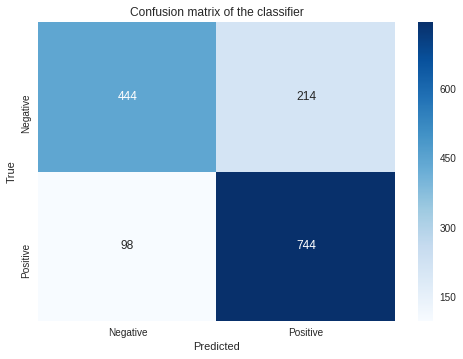

**************************************************
The True Positive Rate observed is 0.8836104513064132
The True Negative Rate observed is 0.6747720364741642
The False Positive Rate observed is 0.3252279635258359
The False Negative Rate observed is 0.1163895486935867
**************************************************
The stats observed for confusion matrix are:
population: 1500
P: 842
N: 658
PositiveTest: 958
NegativeTest: 542
TP: 744
TN: 444
FP: 214
FN: 98
TPR: 0.8836104513064132
TNR: 0.6747720364741642
PPV: 0.7766179540709812
NPV: 0.8191881918819188
FPR: 0.3252279635258359
FDR: 0.22338204592901878
FNR: 0.1163895486935867
ACC: 0.792
F1_score: 0.8266666666666667
MCC: 0.5767908789259225
informedness: 0.5583824877805774
markedness: 0.5958061459529
prevalence: 0.5613333333333334
LRP: 2.7168956867271956
LRN: 0.17248721405491
DOR: 15.751287430860195
FOR: 0.18081180811808117


The number of words available are 104543


In [0]:
df = xgb_gbdt(train_tf_idf, y_train, test_tf_idf, y_test, words, 'TFIDF_GBDT')

In [0]:
df.sort_values(['Coefficients'], ascending=False).head(15)

,Coefficients,Words
51381,0.035791,like
90391,0.033476,tast
71166,0.023504,product
34662,0.020655,flavor
39707,0.020299,good
53847,0.020299,love
63263,0.020121,one
38252,0.018875,get
97797,0.016382,use
40884,0.014779,great


The optimal base learners found using GridSearchCV is 100
The best CV value found is 0

The test accuracy of SVM for n_estimators = 100 is 76.066667%

The test precision of SVM for n_estimators = 100 is 72.135655%

The test recall of SVM for n_estimators = 100 is 93.467933%

The test f1 score of SVM for n_estimators = 100 is 81.427832%
**************************************************
[[354 304]
 [ 55 787]]


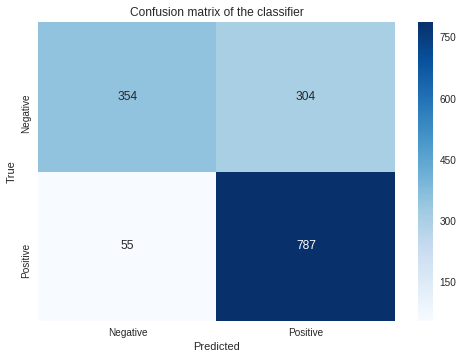

**************************************************
The True Positive Rate observed is 0.9346793349168646
The True Negative Rate observed is 0.5379939209726444
The False Positive Rate observed is 0.46200607902735563
The False Negative Rate observed is 0.06532066508313539
**************************************************
The stats observed for confusion matrix are:
population: 1500
P: 842
N: 658
PositiveTest: 1091
NegativeTest: 409
TP: 787
TN: 354
FP: 304
FN: 55
TPR: 0.9346793349168646
TNR: 0.5379939209726444
PPV: 0.7213565536205316
NPV: 0.8655256723716381
FPR: 0.46200607902735563
FDR: 0.27864344637946836
FNR: 0.06532066508313539
ACC: 0.7606666666666667
F1_score: 0.8142783238489395
MCC: 0.5266911168639562
informedness: 0.47267325588950904
markedness: 0.5868822259921698
prevalence: 0.5613333333333334
LRP: 2.0230888236029503
LRN: 0.12141524752740983
DOR: 16.662559808612443
FOR: 0.13447432762836187


The number of words available are 104543


In [0]:
df = rf_classifier(train_tf_idf, y_train, test_tf_idf, y_test, words, 'TFIDF_RF')

In [0]:
df.sort_values(['Coefficients'], ascending=False).head(15)

,Coefficients,Words
40884,0.008910,great
25703,0.007758,disappoint
53847,0.007391,love
100111,0.005160,wast
8062,0.004826,best
93656,0.004156,threw
100142,0.003755,wast money
76328,0.003712,return
39707,0.003697,good
5445,0.003613,aw


# Word2Vec

In [0]:
import pandas as pd
final = pd.read_csv("grouped_data_200.csv")
p = final.groupby('Score')
pos = p.get_group('Positive') #Gets the groups with Positive score
neg = p.get_group('Negative') #Gets the groups with Negative score
pos_2000 = pos.sample(12000) #Gets 12000 reviews of positive and 8000 negative scores
neg_2000 = neg.sample(8000)
grouped_data = pd.concat([pos_2000, neg_2000], ignore_index = True) #This data now contains positive and negative data in order.
grouped_data.dropna(inplace = True) #Drops rows with Nan
grouped_data.reset_index(inplace=True) #Replaces missing indexes
grouped_data.drop(['Unnamed: 0', 'Unnamed: 0.1'], axis=1, inplace=True)
grouped_data = grouped_data.sort_values('Time', axis=0, ascending=True, kind='quicksort')
scores=grouped_data['Score']
print("The shape of grouped data is {}".format(grouped_data.shape))

The shape of grouped data is (19997, 12)


Observations:
A csv file is imported which consists of 200000 data points. These data points are already sorted on the basis of time. We create a new dataframe with over 20000 data points.

In [0]:
x_train, x_test, y_train, y_test = train_test_split(grouped_data,scores,test_size=0.3,shuffle=False)

Observations: Data is split into train and test.

In [0]:
list_of_sent=[]
for sent in x_train['CleanedText'].values: #Splits sentences into words and stores it in a list
    list_of_sent.append(sent.split())
print(x_train['CleanedText'].values[9])
print("*****************************************************************")
print(list_of_sent[9])

far ive tri breakfest blend columbian sumatra verona winter blend hous blend special christma blend one year diffrent spicy look forward tri blend eventu ive tri far french roast probabl french winter blend french roast excel tast deep dark bean smooth smoki tast absolut delici smell great would recomend love dark coffe alot tast excel high recomend
*****************************************************************
['far', 'ive', 'tri', 'breakfest', 'blend', 'columbian', 'sumatra', 'verona', 'winter', 'blend', 'hous', 'blend', 'special', 'christma', 'blend', 'one', 'year', 'diffrent', 'spicy', 'look', 'forward', 'tri', 'blend', 'eventu', 'ive', 'tri', 'far', 'french', 'roast', 'probabl', 'french', 'winter', 'blend', 'french', 'roast', 'excel', 'tast', 'deep', 'dark', 'bean', 'smooth', 'smoki', 'tast', 'absolut', 'delici', 'smell', 'great', 'would', 'recomend', 'love', 'dark', 'coffe', 'alot', 'tast', 'excel', 'high', 'recomend']


Observations: Get a list of all the words in train data.

In [0]:
w2v_train=Word2Vec(list_of_sent,min_count=5,size=100, workers=4) #Initialises the Word2Vec model with words occuring more than 5 times.

w2v_train_words = list(w2v_train.wv.vocab) #This gives a dictionary of words which tells about the uniqueness of a word among other things.
print("number of words that occured minimum 5 times ",len(w2v_train_words))
print("sample words ", w2v_train_words[298:315])

number of words that occured minimum 5 times  5351
sample words  ['instead', 'pour', 'drain', 'finish', 'paid', 'time', 'glass', 'entir', 'encourag', 'remov', 'air', 'qualiti', 'replac', 'cork', 'itali', 'juic', 'orang']


Observations: Train the word2vec model on the obtained list of train words.

In [0]:
sent_vectors = [];
sent_list = []
for sent in x_test['CleanedText'].values:
    sent_list.append(sent.split())
for sent in sent_list: # For a sentence in the previously created list of sentences
    sent_vec = np.zeros(100) # As word vectors are of zero length, returns an array of size 50 filled with zeros
    i = 0; # Number of words with a valid vector in the sentence/review
    for word in sent: # For each word in a review/sentence
        if word in w2v_train_words:
            vec = w2v_train.wv[word] #Gets the corresponding vector for the word
            sent_vec += vec
            i += 1
    if i != 0:
        sent_vec /= i
    sent_vectors.append(sent_vec)
print(len(sent_vectors))
print(len(sent_vectors[0]))

6000
100


Observations: Gets the sentence vectors for test data.

In [0]:
sent_vectors_train = [];
sent_list = []
for sent in x_train['CleanedText'].values:
    sent_list.append(sent.split())
for sent in sent_list: # For a sentence in the previously created list of sentences
    sent_vec = np.zeros(100) # As word vectors are of zero length, returns an array of size 50 filled with zeros
    i = 0; # Number of words with a valid vector in the sentence/review
    for word in sent: # For each word in a review/sentence
        if word in w2v_train_words:
            vec = w2v_train.wv[word] #Gets the corresponding vector for the word
            sent_vec += vec
            i += 1
    if i != 0:
        sent_vec /= i
    sent_vectors_train.append(sent_vec)
print(len(sent_vectors_train))
print(len(sent_vectors_train[0]))

13997
100


Observations: Gets the sentence vectors for train data

In [0]:
from sklearn.preprocessing import normalize
data_train=normalize(sent_vectors_train)
data_test=normalize(sent_vectors)

Observations: Normalize the data.

The optimal base learners found using GridSearchCV is 300
The optimal max depth found using GridSearchCV is 15
The optimal learning rate found using GridSearchCV is 0.1
The best CV value found is 11

The test accuracy of SVM for max_depth = 15 is 80.683333%

The test precision of SVM for max_depth = 15 is 81.640625%

The test recall of SVM for max_depth = 15 is 85.380800%

The test f1 score of SVM for max_depth = 15 is 83.468835%
**************************************************
[[1915  658]
 [ 501 2926]]


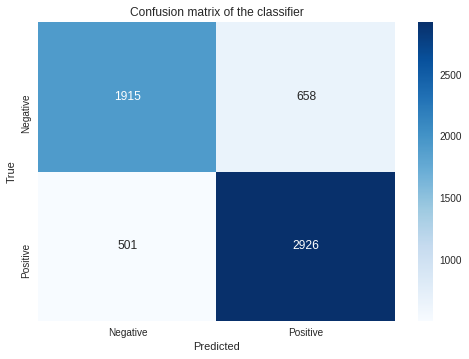

**************************************************
The True Positive Rate observed is 0.8538079953311934
The True Negative Rate observed is 0.7442673921492421
The False Positive Rate observed is 0.25573260785075785
The False Negative Rate observed is 0.14619200466880652
**************************************************
The stats observed for confusion matrix are:
population: 6000
P: 3427
N: 2573
PositiveTest: 3584
NegativeTest: 2416
TP: 2926
TN: 1915
FP: 658
FN: 501
TPR: 0.8538079953311934
TNR: 0.7442673921492421
PPV: 0.81640625
NPV: 0.7926324503311258
FPR: 0.25573260785075785
FDR: 0.18359375
FNR: 0.14619200466880652
ACC: 0.8068333333333333
F1_score: 0.8346883468834688
MCC: 0.6035321505032842
informedness: 0.5980753874804354
markedness: 0.609038700331126
prevalence: 0.5711666666666667
LRP: 3.3386747294637704
LRN: 0.19642403551584292
DOR: 16.99728203168132
FOR: 0.20736754966887416




**********************************************************************


In [0]:
df = xgb_gbdt(data_train, y_train, data_test, y_test, list_of_sent)

The optimal base learners found using GridSearchCV is 600
The best CV value found is 5

The test accuracy of SVM for n_estimators = 600 is 80.050000%

The test precision of SVM for n_estimators = 600 is 80.564693%

The test recall of SVM for n_estimators = 600 is 85.760140%

The test f1 score of SVM for n_estimators = 600 is 83.081272%
**************************************************
[[1864  709]
 [ 488 2939]]


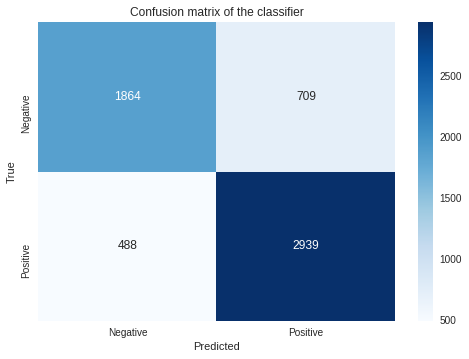

**************************************************
The True Positive Rate observed is 0.8576014006419609
The True Negative Rate observed is 0.7244461717839098
The False Positive Rate observed is 0.27555382821609015
The False Negative Rate observed is 0.1423985993580391
**************************************************
The stats observed for confusion matrix are:
population: 6000
P: 3427
N: 2573
PositiveTest: 3648
NegativeTest: 2352
TP: 2939
TN: 1864
FP: 709
FN: 488
TPR: 0.8576014006419609
TNR: 0.7244461717839098
PPV: 0.8056469298245614
NPV: 0.7925170068027211
FPR: 0.27555382821609015
FDR: 0.1943530701754386
FNR: 0.1423985993580391
ACC: 0.8005
F1_score: 0.8308127208480566
MCC: 0.5900507327566098
informedness: 0.5820475724258707
markedness: 0.5981639366272824
prevalence: 0.5711666666666667
LRP: 3.1122826570546764
LRN: 0.19656201510098426
DOR: 15.833591528127817
FOR: 0.20748299319727892




**********************************************************************


In [0]:
df = rf_classifier(data_train, y_train, data_test, y_test, list_of_sent)

# TFIDF Word2Vec

In [3]:
import pandas as pd
final = pd.read_csv("grouped_data_200.csv")
p = final.groupby('Score')
pos = p.get_group('Positive') #Gets the groups with Positive score
neg = p.get_group('Negative') #Gets the groups with Negative score
pos_2000 = pos.sample(12000) #Gets 12000 reviews of positive and 8000 negative scores
neg_2000 = neg.sample(8000)
grouped_data = pd.concat([pos_2000, neg_2000], ignore_index = True) #This data now contains positive and negative data in order.
grouped_data.dropna(inplace = True) #Drops rows with Nan
grouped_data.reset_index(inplace=True) #Replaces missing indexes
grouped_data.drop(['Unnamed: 0', 'Unnamed: 0.1'], axis=1, inplace=True)
grouped_data = grouped_data.sort_values('Time', axis=0, ascending=True, kind='quicksort')
scores=grouped_data['Score']
print("The shape of grouped data is {}".format(grouped_data.shape))

The shape of grouped data is (19998, 12)


Observations:
A csv file is imported which consists of 200000 data points. These data points are already sorted on the basis of time. We create a new dataframe with over 20000 data points.

In [0]:
x_train, x_test, y_train, y_test = train_test_split(grouped_data,scores,test_size=0.3,shuffle=False)

Observations: Data is split into train and test datasets.

In [5]:
list_of_sent=[]
for sent in x_train['CleanedText'].values: #Splits sentences into words and stores it in a list
    list_of_sent.append(sent.split())
print(x_train['CleanedText'].values[9])
print("*****************************************************************")
print(list_of_sent[9])

yes summer come rather drink tea sweet breakfast cereal consid take glass fill ice pour limead add shot cherri syrup stir shake swizzl content
*****************************************************************
['yes', 'summer', 'come', 'rather', 'drink', 'tea', 'sweet', 'breakfast', 'cereal', 'consid', 'take', 'glass', 'fill', 'ice', 'pour', 'limead', 'add', 'shot', 'cherri', 'syrup', 'stir', 'shake', 'swizzl', 'content']


Observations: Get a list of all the words in train data.

In [6]:
w2v_train=Word2Vec(list_of_sent,min_count=5,size=100, workers=4) #Initialises the Word2Vec model with words occuring more than 5 times.

w2v_train_words = list(w2v_train.wv.vocab) #This gives a dictionary of words which tells about the uniqueness of a word among other things.
print("number of words that occured minimum 5 times ",len(w2v_train_words))
print("sample words ", w2v_train_words[298:315])

number of words that occured minimum 5 times  5368
sample words  ['visual', 'joke', 'charact', 'wait', 'room', 'laugh', 'begin', 'main', 'death', 'minut', 'balanc', 'car', 'wood', 'edg', 'bridg', 'fall', 'manag']


Observations:
Word2Vec model is built. We can see the number of times a word occured minimum 5 times.

In [0]:
tf_idf_vect = TfidfVectorizer(ngram_range=(1,2))
vocab_tf_idf = tf_idf_vect.fit(x_train['CleanedText'].values) #Converts to a sparse matrix of TF-IDF vectors.
train_tf_idf = tf_idf_vect.transform(x_train['CleanedText'].values)
test_tf_idf = tf_idf_vect.transform(x_test['CleanedText'].values)
tfidf_feat = tf_idf_vect.get_feature_names()
dictionary = dict(zip(tfidf_feat, list(tf_idf_vect.idf_)))

Observations:
We build the vocabulary of TF-IDF on train data and obtain the vectors of train and test data.

In [8]:
sent_vectors_train = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
sent_list = []
for sent in x_train['CleanedText'].values:
    sent_list.append(sent.split())
for sent in sent_list: # for each review/sentence 
    sent_vec = np.zeros(100) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_train_words:
            try:
                vec = w2v_train.wv[word] # obtain the tf_idfidf of a word in a sentence/review
                tf_idf = tf_idf = dictionary[word]*sent.count(word)
                sent_vec += (vec * tf_idf)
                weight_sum += tf_idf
            except:
                pass
    if weight_sum != 0:
        sent_vec /= weight_sum
    sent_vectors_train.append(sent_vec)
    row += 1
print(len(sent_vectors_train))
print(len(sent_vectors_train[0]))

13998
100


Observations:
The vector form of train data is obtained.

In [9]:
sent_vectors_test = [];
row=0
sent_list = []
for sent in x_test['CleanedText'].values:
    sent_list.append(sent.split())
for sent in sent_list: # For a sentence in the previously created list of sentences
    sent_vec = np.zeros(100) # As word vectors are of zero length, returns an array of size 50 filled with zeros
    i = 0; # Number of words with a valid vector in the sentence/review
    for word in sent: # For each word in a review/sentence
        if word in w2v_train_words:
            try:
                vec = w2v_train.wv[word] #Gets the corresponding vector for the word
                tf_idf = tf_idf = dictionary[word]*sent.count(word)
                sent_vec += (vec * tf_idf)
                i += tf_idf
            except:
                pass
    if i != 0:
        sent_vec /= i
    sent_vectors_test.append(sent_vec)
    row+=1
print(len(sent_vectors_test))
print(len(sent_vectors_test[0]))

6000
100


Observations:
The vector form of test data is obtained.

In [0]:
from sklearn.preprocessing import normalize
data_train=normalize(sent_vectors_train)
data_test=normalize(sent_vectors_test)

Observations: Data is normalized.

The optimal base learners found using GridSearchCV is 300
The optimal max depth found using GridSearchCV is 10
The optimal learning rate found using GridSearchCV is 0.1
The best CV value found is 8

The test accuracy of SVM for max_depth = 10 is 76.816667%

The test precision of SVM for max_depth = 10 is 76.371992%

The test recall of SVM for max_depth = 10 is 84.530221%

The test f1 score of SVM for max_depth = 10 is 80.244283%
**************************************************
[[1784  874]
 [ 517 2825]]


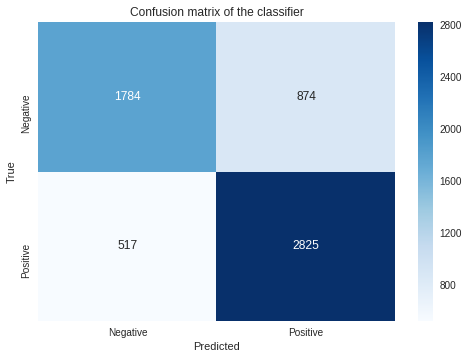

**************************************************
The True Positive Rate observed is 0.8453022142429683
The True Negative Rate observed is 0.6711813393528969
The False Positive Rate observed is 0.3288186606471031
The False Negative Rate observed is 0.15469778575703172
**************************************************
The stats observed for confusion matrix are:
population: 6000
P: 3342
N: 2658
PositiveTest: 3699
NegativeTest: 2301
TP: 2825
TN: 1784
FP: 874
FN: 517
TPR: 0.8453022142429683
TNR: 0.6711813393528969
PPV: 0.7637199243038659
NPV: 0.7753150803998262
FPR: 0.3288186606471031
FDR: 0.2362800756961341
FNR: 0.15469778575703172
ACC: 0.7681666666666667
F1_score: 0.8024428348245988
MCC: 0.5276388108753248
informedness: 0.5164835535958652
markedness: 0.5390350047036923
prevalence: 0.557
LRP: 2.5707245829036722
LRN: 0.2304858265371022
DOR: 11.1535039769131
FOR: 0.22468491960017384




**********************************************************************


In [11]:
df = xgb_gbdt(data_train, y_train, data_test, y_test, list_of_sent)

The optimal base learners found using GridSearchCV is 700
The best CV value found is 6

The test accuracy of SVM for n_estimators = 700 is 75.966667%

The test precision of SVM for n_estimators = 700 is 74.434156%

The test recall of SVM for n_estimators = 700 is 86.594853%

The test f1 score of SVM for n_estimators = 700 is 80.055325%
**************************************************
[[1664  994]
 [ 448 2894]]


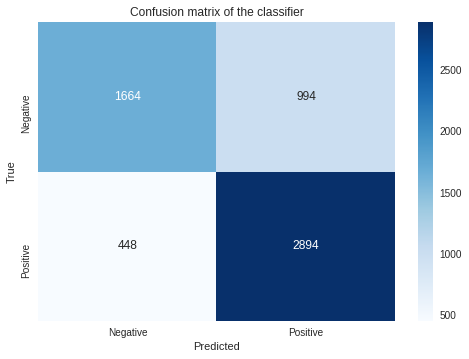

**************************************************
The True Positive Rate observed is 0.8659485338120886
The True Negative Rate observed is 0.6260346124905944
The False Positive Rate observed is 0.37396538750940556
The False Negative Rate observed is 0.13405146618791142
**************************************************
The stats observed for confusion matrix are:
population: 6000
P: 3342
N: 2658
PositiveTest: 3888
NegativeTest: 2112
TP: 2894
TN: 1664
FP: 994
FN: 448
TPR: 0.8659485338120886
TNR: 0.6260346124905944
PPV: 0.7443415637860082
NPV: 0.7878787878787878
FPR: 0.37396538750940556
FDR: 0.25565843621399176
FNR: 0.13405146618791142
ACC: 0.7596666666666667
F1_score: 0.8005532503457815
MCC: 0.5117064032610563
informedness: 0.49198314630268314
markedness: 0.5322203516647961
prevalence: 0.557
LRP: 2.3155847111393677
LRN: 0.2141278828891037
DOR: 10.81402701925841
FOR: 0.21212121212121213




**********************************************************************


In [12]:
df = rf_classifier(data_train, y_train, data_test, y_test, list_of_sent)

# Summary and  Conclusions

1) Import the csv file containing pre processed data which is already arranged on the basis of time.

2) Two functions are created for DecisionTreeClassifier and to plot max depth vs errors.

3) The first function performs GridSearchCv on n_estimators, max_depth, learning_rate and finds the right hyper parameters for XGBClassifier. Then the model is fitted and its respective accuracy and precision values are obtained. Then a Confusion matrix is plotted and its various values like TPR, TNR, FPR, FNR are obtained. Then a dataframe is constructed with all the words and their feature importances and it is given as output.

4) The second function performs GridSearchCv on n_estimators and finds the right hyper parameter for RandomForestClassifier. Then the model is fitted and its respective accuracy and precision values are obtained. Then a Confusion matrix is plotted and its various values like TPR, TNR, FPR, FNR are obtained. Then a dataframe is constructed with all the words and their feature importances and it is given as output.

5) These functions are applied on Bag of Words, TFIDF, avg Word2Vec and TFIDF Word2Vec.

In [13]:
x = PrettyTable()
x.field_names = ["Featurization","Model","Hyper Parameter", "Test Accuracy","Precision","Recall","F1 Score"]
x.add_row(["Bag of Words","GBDT","n_estimators = 300","85.73%", "85.34%", "89.25%", "87.57%"])
x.add_row(["","","max_depth = 10","", "", "", ""])
x.add_row(["","","learning_rate = 0.2","", "", "", ""])
x.add_row(["","RF","n_estimators = 400","83.60%", "80.35%", "93.53%", "86.44%"])
x.add_row(["","","","","","",""])
x.add_row(["TFIDF","GBDT","n_estimators = 200","79.20%", "77.66%", "88.36%", "82.66%"])
x.add_row(["","","max_depth = 10","", "", "", ""])
x.add_row(["","","learning_rate = 0.1","", "", "", ""])
x.add_row(["","RF","n_estimators = 100","76.06%", "72.13%", "93.46%", "81.42%"])
x.add_row(["","","","","","",""])
x.add_row(["Avg Word2Vec","GBDT","n_estimators = 300","80.68%", "81.64%", "85.38%", "85.46%"])
x.add_row(["","","max_depth = 15","", "", "", ""])
x.add_row(["","","learning_rate = 0.1","", "", "", ""])
x.add_row(["","RF","n_estimators = 600","80.05%", "80.56%", "85.76%", "83.08%"])
x.add_row(["","","","","","",""])
x.add_row(["TFIDF Word2Vec","GBDT","n_estimators = 300","76.81%", "76.37%", "84.53%", "80.24%"])
x.add_row(["","","max_depth = 10","", "", "", ""])
x.add_row(["","","learning_rate = 0.1","", "", "", ""])
x.add_row(["","RF","n_estimators = 700","75.56%", "74.43%", "86.59%", "80.05%"])
x.add_row(["","","","","","",""])


print(x.get_string())

+----------------+-------+---------------------+---------------+-----------+--------+----------+
| Featurization  | Model |   Hyper Parameter   | Test Accuracy | Precision | Recall | F1 Score |
+----------------+-------+---------------------+---------------+-----------+--------+----------+
|  Bag of Words  |  GBDT |  n_estimators = 300 |     85.73%    |   85.34%  | 89.25% |  87.57%  |
|                |       |    max_depth = 10   |               |           |        |          |
|                |       | learning_rate = 0.2 |               |           |        |          |
|                |   RF  |  n_estimators = 400 |     83.60%    |   80.35%  | 93.53% |  86.44%  |
|                |       |                     |               |           |        |          |
|     TFIDF      |  GBDT |  n_estimators = 200 |     79.20%    |   77.66%  | 88.36% |  82.66%  |
|                |       |    max_depth = 10   |               |           |        |          |
|                |       | lea